In [154]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io


In [155]:
rootfolder = '.'

Generating 1-D DCT bais
------------------------


In [156]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

for k in range(M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    if k!= 0:
        DCT[:,k] = [np.sqrt(2/M)*np.cos(k*np.pi*(2*n+1)/(2*M)) for n in range(N)]
    else:
        DCT[:,k] = [np.sqrt(1/M)*np.cos(k*np.pi*(2*n+1)/(2*M)) for n in range(N)]

    
#DCT[:,k] = DCT[:,k] / np.linalg.norm(DCT[:,k]) # normalize the atom

In [157]:
DCT

array([[ 0.08838835,  0.12499059,  0.12496235, ...,  0.0046009 ,
         0.00306765,  0.00153394],
       [ 0.08838835,  0.1249153 ,  0.12466131, ..., -0.01377778,
        -0.00919557, -0.0046009 ],
       [ 0.08838835,  0.12476476,  0.12405994, ...,  0.02287999,
         0.01530133,  0.00766509],
       ...,
       [ 0.08838835, -0.12476476,  0.12405994, ..., -0.02287999,
         0.01530133, -0.00766509],
       [ 0.08838835, -0.1249153 ,  0.12466131, ...,  0.01377778,
        -0.00919557,  0.0046009 ],
       [ 0.08838835, -0.12499059,  0.12496235, ..., -0.0046009 ,
         0.00306765, -0.00153394]])

Display an atom of the dct basis

Text(0.5, 1.0, 'element: 35 from the DCT basis')

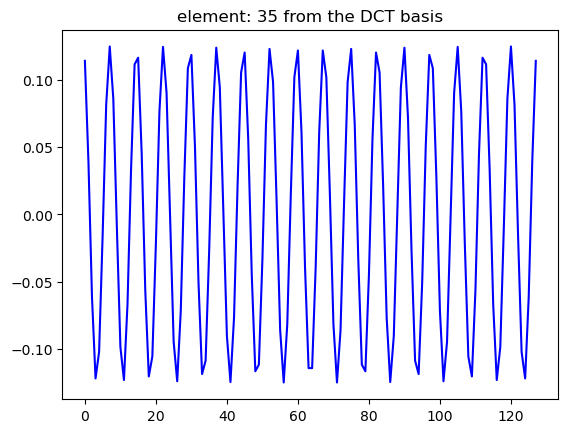

In [158]:
k = 34
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [159]:
is_DCT_orth = True
dot = -1
for k in range(M):
    for l in range(M):
        if k == l:
            dot = np.dot(DCT[:, k], DCT[:, l])
            is_DCT_orth = is_DCT_orth and (dot >= 0.999999999 and dot <= 1.000000001)
        else:
            dot = np.dot(DCT[:, k], DCT[:, l])
            is_DCT_orth = is_DCT_orth and  (dot >= -0.000000001 and dot <= 0.000000001)
        if not is_DCT_orth:
                print(f'k: {k}, l: {l}')
                break
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

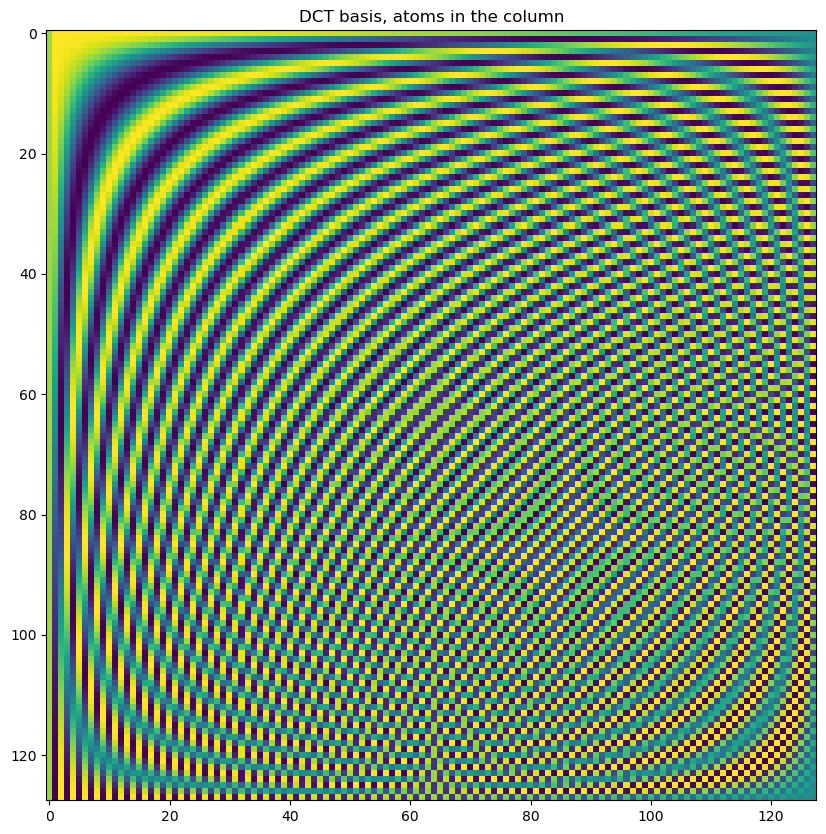

In [160]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [161]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = sp.fftpack.idct(a, norm='ortho')


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

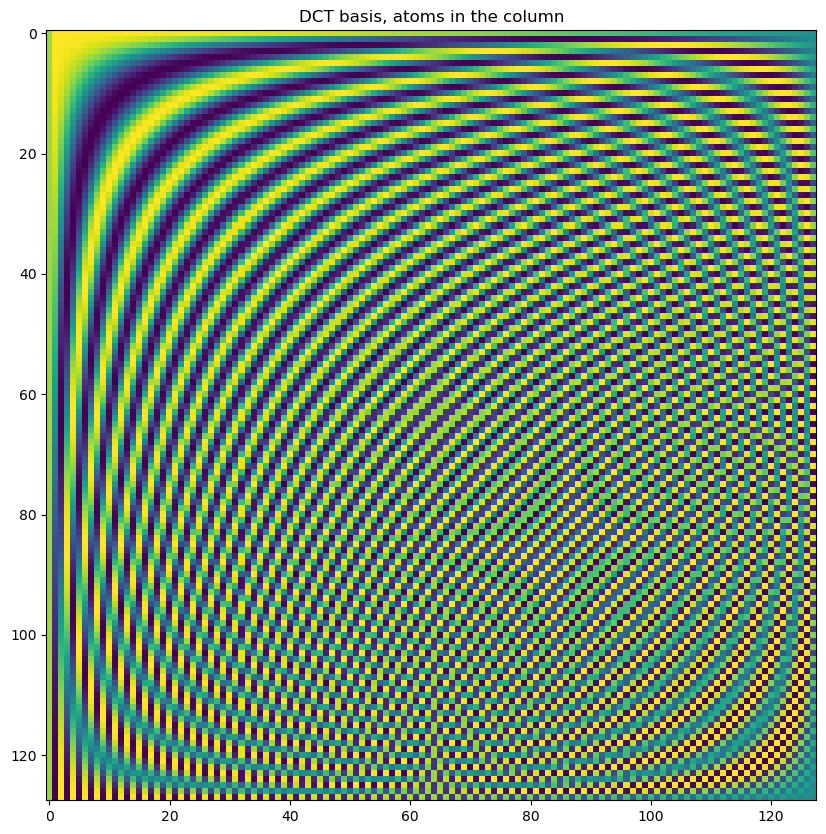

In [162]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Check that D and DCT defined above coincide

In [163]:
is_DCT_equal_D = np.allclose(D, DCT)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [164]:
temp = scipy.io.loadmat(f'{rootfolder}/data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
SSave = S.copy()
X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [165]:
for i in range(nBeats):
    X[:, i] = np.dot(D.T, S[:, i])

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

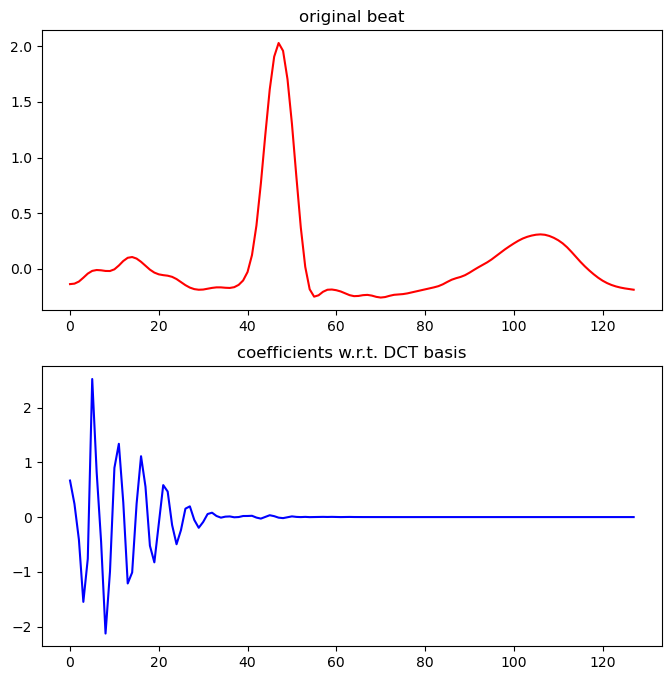

In [166]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [167]:
S_hat_D = np.dot(D, X)


Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [168]:
is_reconstruction_perfect = np.allclose(S, S_hat_D)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [169]:
sigma_noise = 0.1
S0 = S.copy()
S0 = S0 + sigma_noise * np.random.normal(size=S0.shape)

X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D


Compute the representation coefficients

In [170]:
for i in range(nBeats):
    X[:, i] = np.dot(D.T, S0[:, i])

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

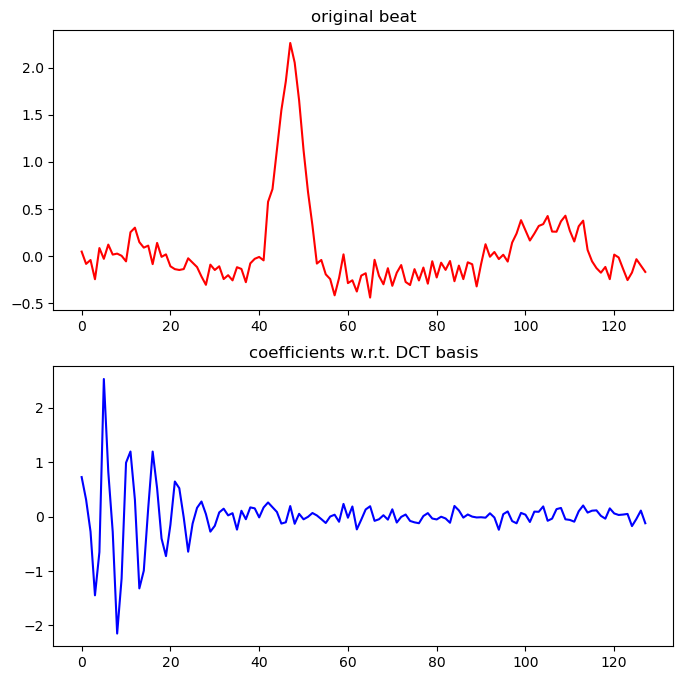

In [171]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S0[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [198]:
X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 21 # sparsity level (try different values)

for i in range(nBeats):
    origSignal = S[:,i]
    noisySignal = S0[:,i]

    # transform each signal separately (analysis)
    x = np.dot(D.T, noisySignal)

    # keep only the L largest coefficients (absolute value)
    XS = np.sort(np.abs(x))[::-1][L+1]
    X_HT[:, i] = np.where(abs(x)>XS,x,0)

    # invert the transformation
    s_hat = np.dot(D,X_HT[:,i])

    S_hat[:, i] = s_hat


Display a signal

C:\Users\chech\AppData\Local\Temp\ipykernel_27320\3261947503.py:12: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  ax2.stem(np.arange(M), X_HT[:, i], 'k')


Text(0.5, 1.0, 'DCT coefficients')

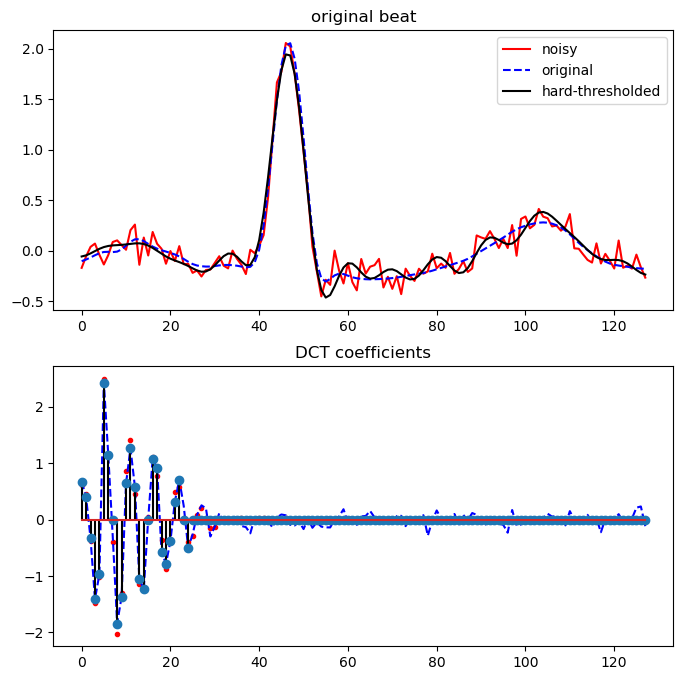

In [199]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S0[:, i], 'r')
ax1.plot(S[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

Text(0.5, 1.0, 'MSE in s_hat vs Original Signal')

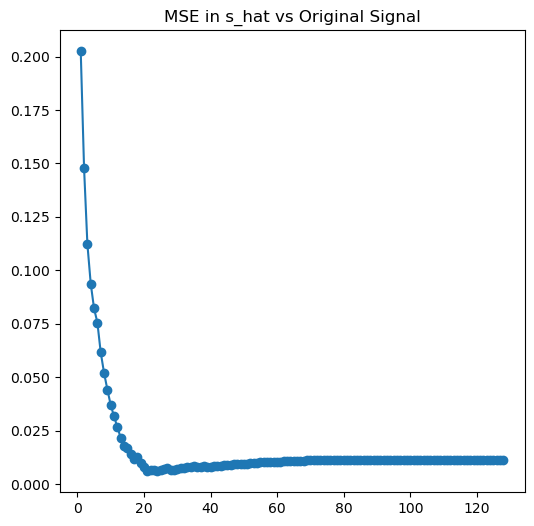

In [206]:
x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = SSave[:, 0]

for L in L_values:
     # transform each signal separately (analysis)
    x = np.dot(D.T, S0[:,0])

    # keep only the L largest coefficients (absolute value)
    #[...]
    XS = np.sort(np.abs(x))[::-1][L-1]
    X_HT = np.where(abs(x)>XS,x,0)

    # invert the transformation
    s_hat = np.dot(D,X_HT)

    mse = (np.square(s_hat-origSignal).mean(axis=0))

    MSE_values[L-1] = mse

plt.figure(figsize=(6,6))
plt.plot(L_values, MSE_values, '-o')
plt.title('MSE in s_hat vs Original Signal')